# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.shared.segment_cellpose import estimate_diameters, segment_cellpose
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

2025-03-08 13:42:04.983933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A1"
TEST_TILE = 186
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ['DAPI','TUBULIN','GH2AX','PHALLOIDIN']
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow", "pure_green"]

# parameters for feature extraction
FOCI_CHANNEL = 2

Loading test image...
Applying illumination correction...
Example corrected image:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


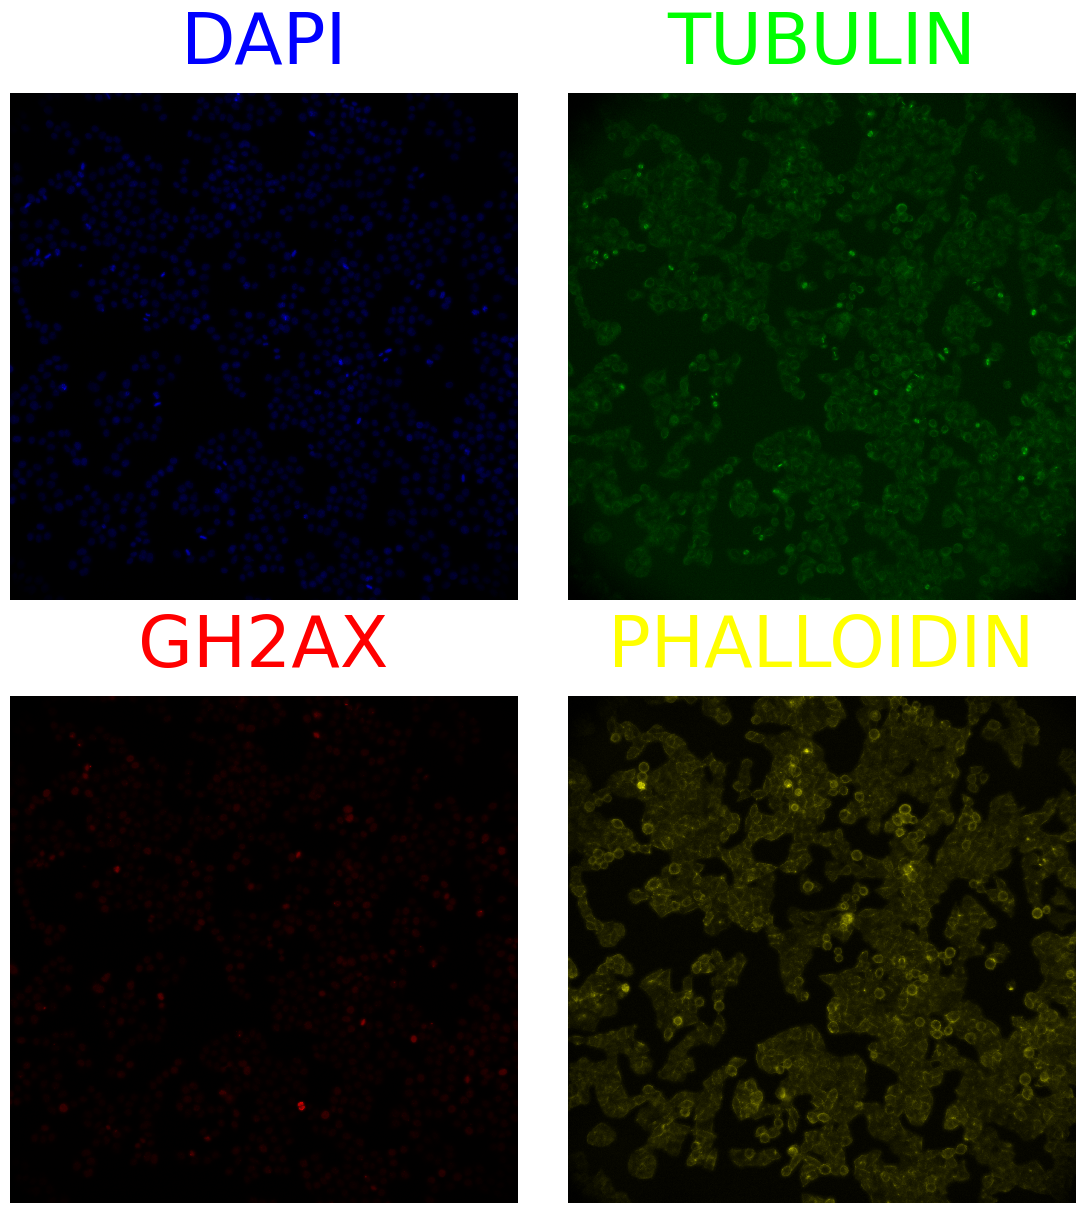

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = True
# Define plate-specific alignments with a dictionary structure
ALIGNMENTS = {  
    # Plate 1: Single cycle, no GFP recapture: [DAPI, GFP, A594, AF750]
    1: {
        "target": 0,  # DAPI
        "source": 2,  # A594
        "riders": [3],  # AF750
        "remove_channel": False
    },

    # Plate 2: Two cycles: [DAPI, GFP, A594] + [A594, AF750]
    2: {
        "steps": [
            {
                "target": 0,  # DAPI (cycle 1)
                "source": 2,  # A594 (cycle 1)
                "riders": [],
                "remove_channel": False
            },
            {
                "target": 2,  # A594 (cycle 1)
                "source": 3,  # A594 (cycle 2)
                "riders": [4],  # AF750 (cycle 2)
                "remove_channel": "source"
            }
        ]
    },
    
    # Plate 3: Single cycle, no GFP recapture: [DAPI, GFP] + [A594, AF750]
    3: {
        "target": 0,  # DAPI
        "source": 2,  # A594
        "riders": [3],  # AF750
        "remove_channel": False
    },
    
    # Plate 4: Single cycle + GFP recapture: [DAPI, GFP, A594, AF750] + [GFP]
    4: {
        "steps": [
            {
                "target": 0,  # DAPI
                "source": 2,  # A594
                "riders": [3],  # AF750
                "remove_channel": False
            },
            {
                "target": 1,  # GFP (cycle 1)
                "source": 4,  # GFP from cycle 2
                "riders": [],
                "remove_channel": "target"
            }
        ]
    },
    
    # Plate 5: Single cycle, no GFP recapture: [DAPI, GFP, A594, AF750]
    5: {
        "target": 0,  # DAPI
        "source": 2,  # A594
        "riders": [3],  # AF750
        "remove_channel": False
    },
    
    # Plate 6: Single cycle + GFP recapture: [DAPI, GFP, A594, AF750] + [GFP]
    6: {
        "steps": [
            {
                "target": 0,  # DAPI
                "source": 2,  # A594
                "riders": [3],  # AF750
                "remove_channel": False
            },
            {
                "target": 1,  # GFP (cycle 1)
                "source": 4,  # GFP from cycle 2
                "riders": [],
                "remove_channel": "target"
            }
        ]
    },
    
    # Plate 7: Single cycle + GFP recapture: [DAPI, GFP, A594, AF750] + [GFP]
    7: {
        "steps": [
            {
                "target": 0,  # DAPI
                "source": 2,  # A594
                "riders": [3],  # AF750
                "remove_channel": False
            },
            {
                "target": 1,  # GFP (cycle 1)
                "source": 4,  # GFP from cycle 2
                "riders": [],
                "remove_channel": "target"
            }
        ]
    },
    
    # Plate 8: Single cycle + GFP recapture: [DAPI, GFP, A594, AF750] + [GFP]
    8: {
        "steps": [
            {
                "target": 0,  # DAPI
                "source": 2,  # A594
                "riders": [3],  # AF750
                "remove_channel": False
            },
            {
                "target": 1,  # GFP (cycle 1)
                "source": 4,  # GFP from cycle 2
                "riders": [],
                "remove_channel": "target"
            }
        ]
    }
}

In [6]:
if ALIGN:
    print("Aligning channels...")
    # Get alignment configuration for the current plate
    plate_config = ALIGNMENTS.get(TEST_PLATE)
    
    if plate_config:
        # Start with the corrected image
        aligned_image = corrected_image
        
        # Check if this is a multi-step alignment (has "steps" key)
        if "steps" in plate_config:
            print(f"Performing multi-step alignment for plate {TEST_PLATE}...")
            
            # Apply each alignment step in sequence
            for step_num, step in enumerate(plate_config["steps"], 1):
                print(f"  Step {step_num}: Aligning {step['target']} (target) with {step['source']} (source)")
                aligned_image = align_phenotype_channels(
                    aligned_image,
                    target=step["target"],
                    source=step["source"],
                    riders=step["riders"],
                    remove_channel=step["remove_channel"],
                )
        else:
            # Single-step alignment
            print(f"Performing single-step alignment for plate {TEST_PLATE}...")
            aligned_image = align_phenotype_channels(
                corrected_image,
                target=plate_config["target"],
                source=plate_config["source"],
                riders=plate_config["riders"],
                remove_channel=plate_config["remove_channel"],
            )
    else:
        # No configuration found for this plate
        print(f"Warning: No alignment configuration found for plate {TEST_PLATE}")
        aligned_image = corrected_image
else:
    aligned_image = corrected_image

Aligning channels...
Performing single-step alignment for plate 1...


## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [7]:
# Common parameters
CYTO_CHANNEL = "PHALLOIDIN"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    FLOW_THRESHOLD = 0.4
    CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

Estimating optimal cell and nuclei diameters...


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0


Estimating nuclei diameters...


INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


Estimated nuclear diameter: 41.3 pixels
Estimating cell diameters...
Estimated cell diameter: 72.3 pixels


Segmenting image with cellpose...


INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 64.49 sec
INFO:cellpose.models:channels set to [2, 3]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 179.36 sec
found 1212 nuclei before removing edges
found 1160 cells before removing edges


removing edges


found 1165 nuclei before reconciling
found 1095 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 7
Cells with 1 nuclei: 1072
Cells with 2 nuclei: 16
--------------------------



found 1088 nuclei/cells after reconciling


Number of nuclei segmented: 1088
Number of cells segmented: 1088
Example microplots for DAPI channel and nuclei segmentation:


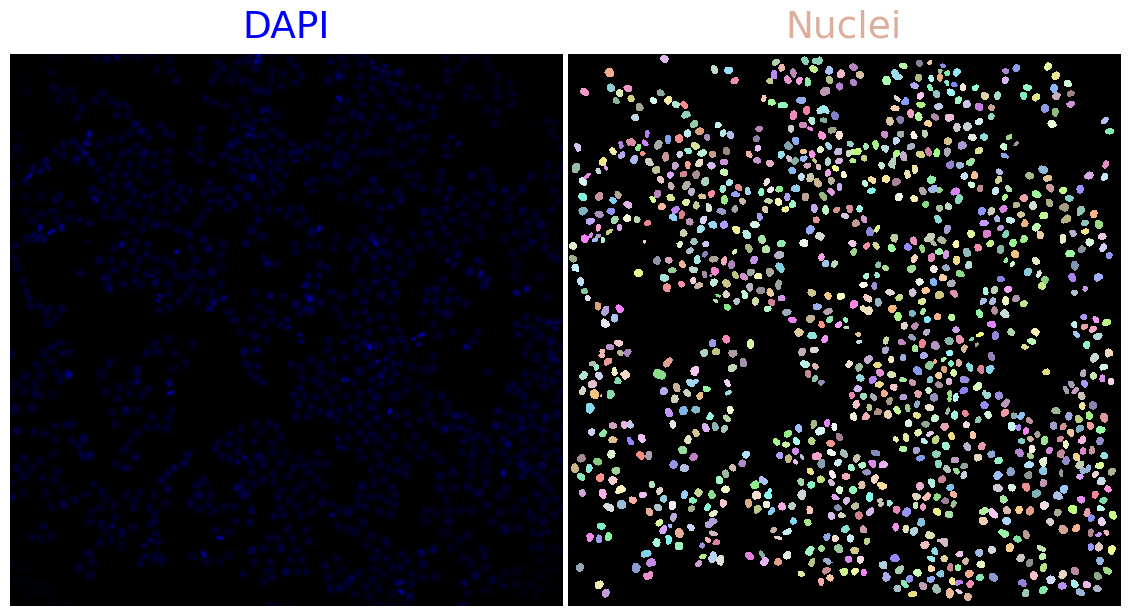

Example microplots for merged channels and cells segmentation:


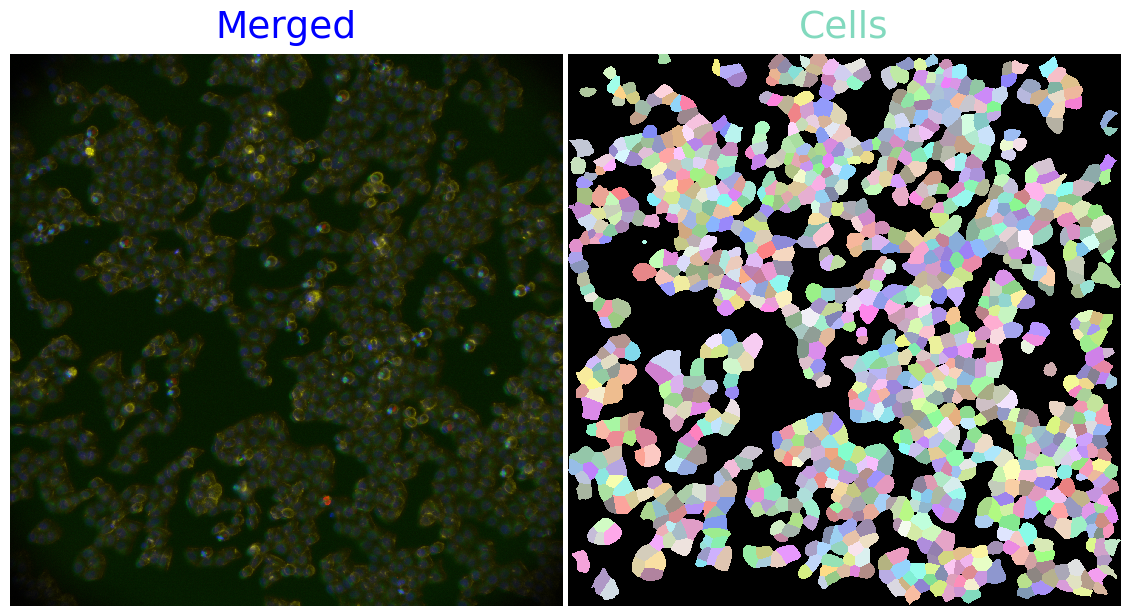

Example microplot for phenotype data annotated with segmentation:


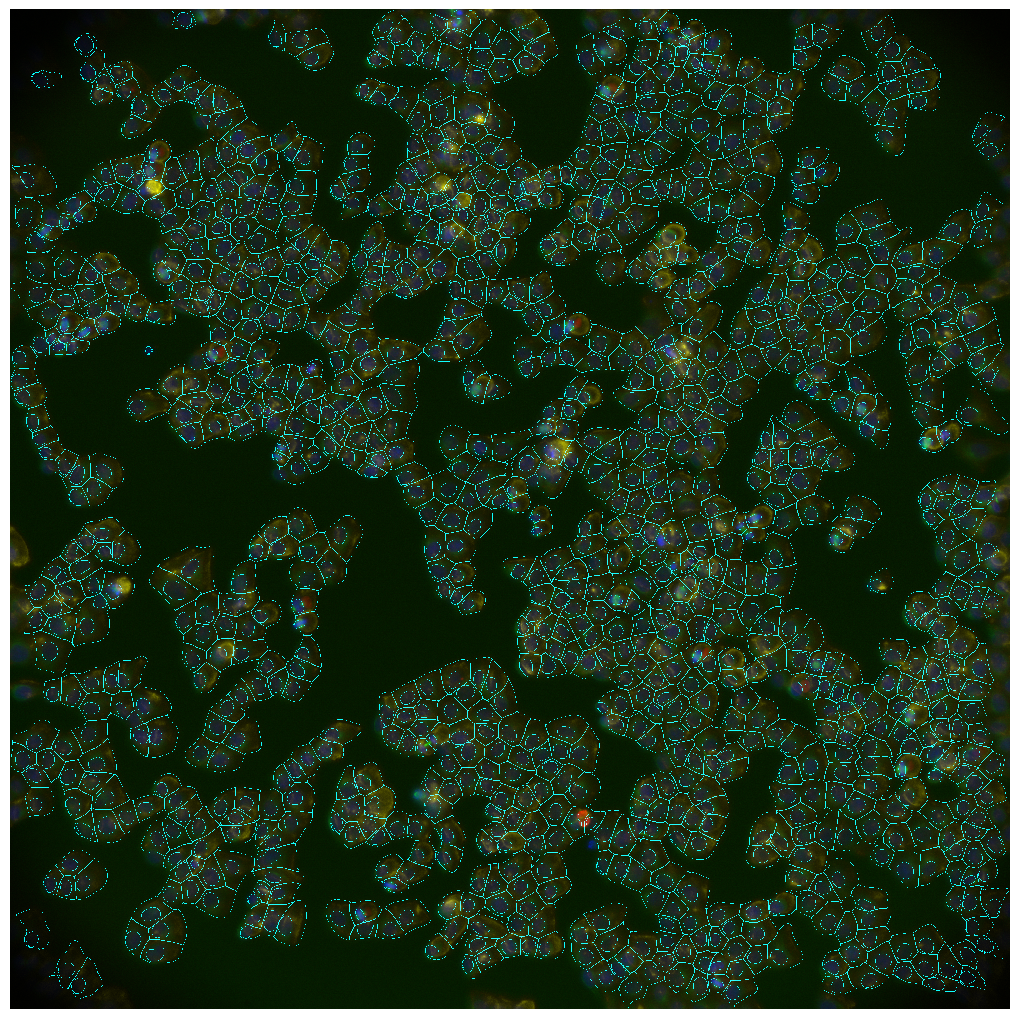

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1088


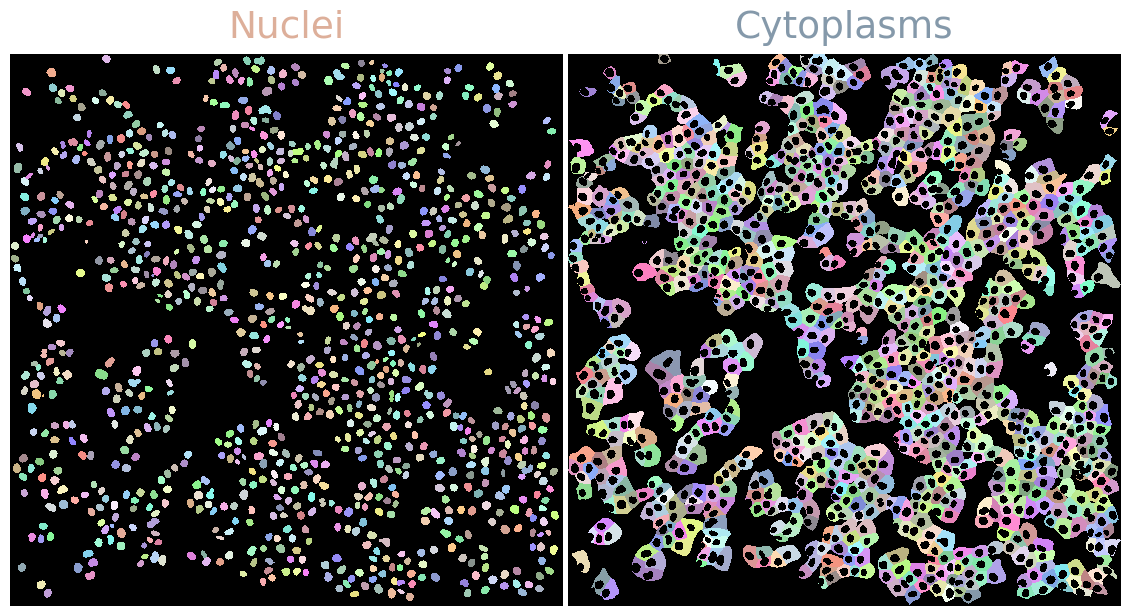

In [8]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei, cells = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS[0:4],
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS[0:4] + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

In [9]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    aligned_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_TUBULIN_int  nucleus_GH2AX_int  \
0         1           5298864              1208723             938775   
1         2           3984711              1385194             930531   
2         3          11745271              3374442            3251391   
3         4           3519791               632567             496699   
4         5           4963868              1589916            1376363   
...     ...               ...                  ...                ...   
1083   1084           3770931              1507120             893329   
1084   1085           3201610              1408874             862274   
1085   1086           7559921              1273795             724363   
1086   1087           2334849               987254             818320   
1087   1088           6920739              1675663            1293181   

      nucleus_PHALLOIDIN_int  nucleus_DAPI_mean  nucleus_TUBULIN_mean  \
0                     933316        3525.524950            804.206919   
1                    1035649        3203.143891           1113.500000   
2                    2840267        6088.787455           1749.321928   
3                     542103        6330.559353           1137.710432   
4                    1558550        3413.939477           1093.477304   
...                      ...                ...                   ...   
1083                  966826        2750.496718           1099.285193   
1084                 1063481        2209.530711            972.307798   
1085                  832488       10602.974755           1786.528752   
1086                 1059187        1524.052872            644.421671   
1087                 1184013        4571.161823           1106.778732   

      nucleus_GH2AX_mean  nucleus_PHALLOIDIN_mean  nucleus_DAPI_std  ...  \
0             624.600798               620.968729        701.969879  ...   
1             748.015273               832.515273        580.573525  ...   
2            1685.531882              1472.403836       3471.925117  ...   
3             893.343525               975.005396       1028.823571  ...   
4             946.604539              1071.905089        551.686715  ...   
...                  ...                      ...               ...  ...   
1083          651.589351               705.197666        346.826598  ...   
1084          595.082126               733.941339        406.527308  ...   
1085         1015.936886              1167.584853       3287.631005  ...   
1086          534.151436               691.375326        256.325848  ...   
1087          854.148613               782.042933        767.907943  ...   

      cell_number_neighbors_1  cell_percent_touching_1  \
0                           0                 0.000000   
1                           2                 0.418733   
2                           3                 0.540166   
3                           1                 0.162630   
4                           2                 0.317269   
...                       ...                      ...   
1083                        4                 0.471795   
1084                        2                 0.462908   
1085                        4                 0.853755   
1086                        3                 0.481366   
1087                        2                 0.366310   

      cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                       172.961517                     214.777078   
1                        49.601864                      68.824634   
2                        57.366867                      72.889961   
3                        66.855893                      67.697995   
4                        67.206214                      74.979058   
...                            ...                            ...   
1083                     70.518269                      71.775131   
1084                     61.372080                      87.113399   
1085                 

In [10]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [11]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "flow_threshold": FLOW_THRESHOLD,
        "cellprob_threshold": CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
        "points_per_side": POINTS_PER_SIDE,
        "points_per_batch": POINTS_PER_BATCH,
        "stability_score_thresh": STABILITY_SCORE_THRESH,
        "pred_iou_thresh": PRED_IOU_THRESH,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "prob_thresh": PROB_THRESH,
        "nms_thresh": NMS_THRESH,
    })

if ALIGN:
    config["phenotype"]["alignments"] = ALIGNMENTS

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)
    
    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)

In [12]:
from lib.shared.rule_utils import get_alignment_params

# Create a simple object with a plate attribute to mimic Snakemake wildcards
class MockWildcards:
    def __init__(self, plate):
        self.plate = str(plate)  # Convert to string as wildcards are strings in Snakemake

# Loop through all 8 plates and print the alignment parameters
for plate in range(1, 9):
    # Create the mock wildcards object with the current plate
    wildcards = MockWildcards(plate)

    # Call the function with correct parameter order
    alignment_params = get_alignment_params(wildcards, config)

    # Print the result to inspect
    print(alignment_params)

{'align': True, 'multi_step': False, 'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}
{'align': True, 'multi_step': True, 'steps': [{'target': 0, 'source': 2, 'riders': [], 'remove_channel': False}, {'target': 2, 'source': 3, 'riders': [4], 'remove_channel': 'source'}]}
{'align': True, 'multi_step': False, 'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}
{'align': True, 'multi_step': True, 'steps': [{'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}, {'target': 1, 'source': 4, 'riders': [], 'remove_channel': 'target'}]}
{'align': True, 'multi_step': False, 'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}
{'align': True, 'multi_step': True, 'steps': [{'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}, {'target': 1, 'source': 4, 'riders': [], 'remove_channel': 'target'}]}
{'align': True, 'multi_step': True, 'steps': [{'target': 0, 'source': 2, 'riders': [3], 'remove_channel': False}, {'target': 1, 'source'

In [13]:
from lib.shared.rule_utils import get_segmentation_params

segmentation_params = get_segmentation_params("phenotype", config)

print(segmentation_params)

{'method': 'cellpose', 'dapi_index': 0, 'cyto_index': 3, 'reconcile': 'contained_in_cells', 'return_counts': True, 'gpu': False, 'cellpose_model': 'cyto3', 'nuclei_diameter': 41.25147987644627, 'cell_diameter': 72.27354112912391, 'flow_threshold': 0.4, 'cellprob_threshold': 0}
